In [ ]:
import sys
from pathlib import Path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from ml_logic.data_preprocessing import clean_data, resample_pings
from ml_logic.model_evaluation import evaluate_horizon

from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)


In [ ]:

#================
# 1. LOAD & PREPROCESS
#=================
df = pd.read_parquet("../data/processed/ais_filtered.parquet")

df = clean_data(df) #remove missing values and clean

df = resample_pings(df, interval='5min') #uniformize pings
print(df.head(2))

        MMSI        BaseDateTime        LAT        LON    SOG   COG  Heading  \
0  205685000 2024-12-23 13:55:00  28.584470 -94.406530  15.30  6.40     11.0   
1  205685000 2024-12-23 14:00:00  28.611775 -94.402755  15.15  6.75     10.0   

   Status  Length  Width  Draft  
0     0.0   180.0   30.0    9.4  
1     0.0   180.0   30.0    9.4  


In [ ]:
#====================
#2. DEFINE MODELS TO COMPARE
#====================
estimators = {
    "LinReg" : LinearRegression(),
    'Lasso': Lasso(),
    "Ridge": Ridge(),
    #the random forest was too slow so reduced some parameters
    "Forests": RandomForestRegressor(
        n_estimators=50,        # Reduced from default 100
        max_depth=15,           # Limit tree depth (crucial for speed)
        min_samples_split=100,  # Stop splitting early
        max_samples=0.5,        # Bootstrap 50% of data per tree
        random_state=273,
        n_jobs=-1               # Use all CPU cores
    ),
    "XGBOOST": XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=273,
        n_jobs=-1
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=273,
        n_jobs=-1,
        verbose=-1
    )
}
# version avec scaling for linear models
estimators_scaled = {
    "LinReg_scaled": Pipeline([
        ('scaler', RobustScaler()),
        ('model', LinearRegression())
    ]),
    "Ridge_scaled": Pipeline([
        ('scaler', RobustScaler()),
        ('model', Ridge(alpha=1.0))
    ]),

    "XGBOOST": XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=273,
        n_jobs=-1
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=273,
        n_jobs=-1,
        verbose=-1
    )
}


Testing horizon: 30min
Target prediction horizon: 30 min. Number of steps: 6
Defining lag windows of 5min, 15min, 30min
Testing model LinReg_scaled
fitting...
predicting...
Testing model Ridge_scaled
fitting...
predicting...
Testing model XGBOOST
fitting...
predicting...
Testing model LightGBM
fitting...
predicting...
Testing horizon: 60min
Target prediction horizon: 60 min. Number of steps: 12
Defining lag windows of 10min, 30min, 60min
Testing model LinReg_scaled
fitting...
predicting...
Testing model Ridge_scaled
fitting...
predicting...
Testing model XGBOOST
fitting...
predicting...
Testing model LightGBM
fitting...
predicting...
Testing horizon: 120min
Target prediction horizon: 120 min. Number of steps: 24
Defining lag windows of 20min, 60min, 120min
Testing model LinReg_scaled
fitting...
predicting...
Testing model Ridge_scaled
fitting...
predicting...
Testing model XGBOOST
fitting...
predicting...
Testing model LightGBM
fitting...
predicting...
Testing horizon: 180min
Target pr

,horizon_min,nb_pings,nb_vessels,Baseline,LinReg_scaled,Ridge_scaled,XGBOOST,LightGBM
0,30,1098845,973,0.983187,1.969484,1.993935,2.235674,2.000040
1,60,1087194,968,1.753313,2.792947,2.812125,2.852234,3.042431
2,120,1064034,961,4.196586,5.305987,5.326163,4.683403,4.837004
3,180,1041000,957,7.010242,7.986361,8.005332,6.508821,6.583354
4,240,1018139,946,10.227127,11.240244,11.262651,9.323697,9.431930
5,300,995513,937,13.287778,13.656682,13.675846,12.368798,11.353459
6,360,973122,929,17.314575,16.468239,16.483527,14.355521,14.059326
7,420,950907,923,18.547231,17.513079,17.525198,15.809711,15.116968
8,480,928864,912,26.288610,22.866135,22.877300,21.915248,20.949232
9,540,907172,897,24.387719,21.703665,21.716903,22.311736,22.436935


In [ ]:
#============================
# 3. MODEL EVALUATIONS PER TIME HORIZON
#============================

horizons = [30, 60, 120, 180, 240, 300, 360, 420,480, 540, 600, 660, 720, 840, 920, 1080, 1800, 2160,2520,2880]
 # 30min, 1h,2h,3h,4h,5h, 6h,9h,12h, 18h,24h,36h, 48h
# for each horizon we want to collect: baseline mae, mae for each model,
# number of pings, number of boats

results = []

for horizon in horizons:

    print(f"Testing horizon: {horizon}min")

    nb_pings, nb_vessels, mae_scores = evaluate_horizon(df= df,
                                        time_horizon= horizon,
                                        estimators= estimators_scaled,
                                        test_size= 0.2,
                                        random_state= 273)

    results.append({"horizon_min": horizon,
                    "nb_pings": nb_pings,
                    "nb_vessels": nb_vessels,
                    **mae_scores
                    }) #unpacking dict of mae scores

#===================
# 4. VISUALIZATION RESULTS
#====================
results_df = pd.DataFrame(results)
results_df

In [ ]:
#============================
# 4. CALCULATE % IMPROVEMENT VS BASELINE
#============================

# list of models
models = estimators_scaled.keys()

for model in models:
    col_name = f'{model}_vs_baseline_%'
    results_df[col_name] = ((results_df['Baseline'] - results_df[model]) / results_df['Baseline'] * 100)


print("RESULTS WITH % IMPROVEMENT VS BASELINE")
print(results_df[['horizon_min', 'Baseline'] + [f'{m}_vs_baseline_%' for m in models]].to_string(index=False))


RESULTS WITH % IMPROVEMENT VS BASELINE
 horizon_min   Baseline  LinReg_scaled_vs_baseline_%  Ridge_scaled_vs_baseline_%  XGBOOST_vs_baseline_%  LightGBM_vs_baseline_%
          30   0.983187                  -100.316292                 -102.803226            -127.390500             -103.424171
          60   1.753313                   -59.295406                  -60.389195             -62.676839              -73.524652
         120   4.196586                   -26.435780                  -26.916561             -11.600306              -15.260441
         180   7.010242                   -13.924179                  -14.194809               7.152697                6.089492
         240  10.227127                    -9.906180                  -10.125273               8.833667                7.775368
         300  13.287778                    -2.776266                   -2.920488               6.915978               14.557132
         360  17.314575                     4.887999            

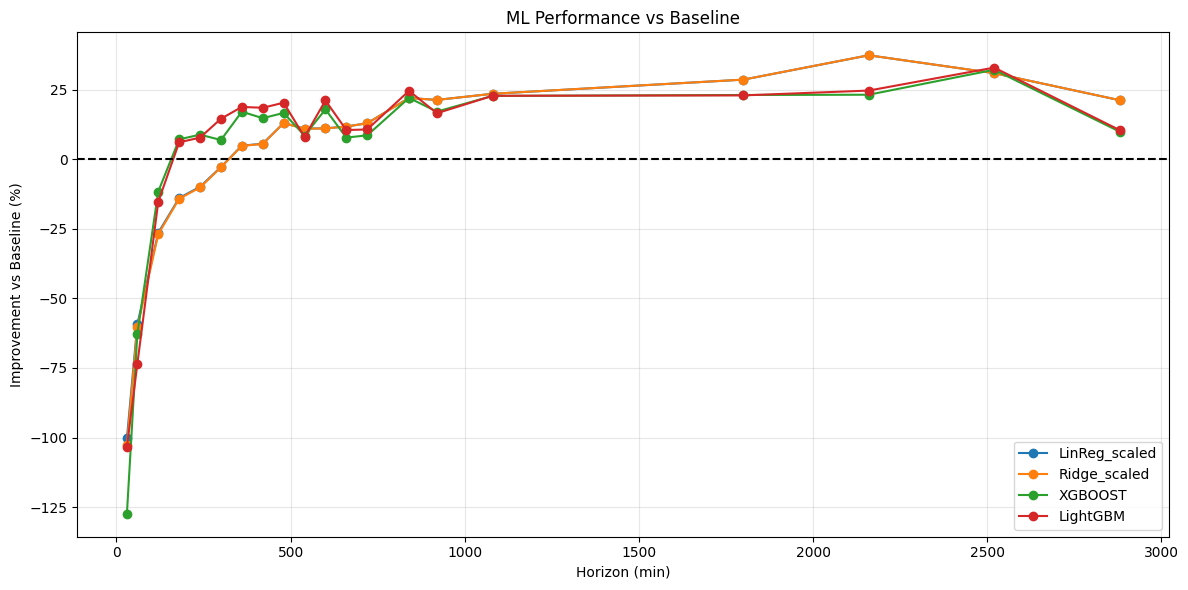

In [5]:
#============================
# 5. VISUALIZATION
#============================

# Préparer les données pour seaborn
plt.figure(figsize=(12, 6))

# Plot chaque modèle
for model in models:
    col_name = f'{model}_vs_baseline_%'
    plt.plot(results_df['horizon_min'], results_df[col_name], marker='o', label=model)

# Ligne de baseline
plt.axhline(0, color='black', linestyle='--', linewidth=1.5)

plt.xlabel('Horizon (min)')
plt.ylabel('Improvement vs Baseline (%)')
plt.title('ML Performance vs Baseline')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig('../visualizations/models_vs_baseline.png', dpi=300)
plt.show()

## Conclusions

### Three Prediction Regimes

**Short-term (< 3h)**: Baseline wins
- Linear extrapolation sufficient (MAE 1-7 km)
- ML models underperform by 11-127%

**Medium-term (3-12h)**: ML becomes useful
- XGBoost/LightGBM beat baseline by +7% to +21%
- Peak performance at 10h: +21% (LightGBM)

**Long-term (12-42h)**: All ML models excel
- Linear models (LinReg/Ridge) surprisingly best: +28% to +37%
- XGBoost/LightGBM also strong: +22% to +33%

### Model Selection

| Horizon | Best Model | Improvement |
|---------|-----------|-------------|
| 0-3h | Baseline | - |
| 3-12h | LightGBM | +14% to +21% |
| 12-42h | LinReg/Ridge | +28% to +37% |

### Validation & Exclusions

**Stability**: Tested with 4 random states → results robust (CV < 7% for XGBoost/LightGBM, < 6% for LinReg/Ridge)

**Excluded models**:
- **Lasso**: L1 regularization incompatible with correlated time series features (MAE 70-100 km, unusable)
- **Random Forest**: High variance across random states (CV 14-15%), not reliable for production


***Will engineer new features to check if it improves performance in Notebook 3***